## Data Analysis
here we are using the databased to extract the data about different goodreads group and trying to understand different genres 
### Step 1 : get the data from database

In [1]:
import os, sys, inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir)
from database_utils import get_query_results

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
get_all_data_query = """
SELECT book.title, book.reviews_cnt, book.ratings_cnt, book.pub_year, book.avg_rating, book.alt_avg_rating, book.author_1_name, book.author_1_avg_rating, genre.name as genre,bc.club_name,bc.book_club_id,genre.genre_id genre_id
FROM book 
join genre_book
on book.book_id = genre_book.book_id
join genre
on genre.genre_id = genre_book.genre_id
join book_club_book bcb
on bcb.book_id =book.book_id
join book_club bc
on bc.book_club_id = bcb.book_club_id
"""

In [3]:
df = get_query_results(get_all_data_query)

In [4]:
df.head()

,title,reviews_cnt,ratings_cnt,pub_year,avg_rating,alt_avg_rating,author_1_name,author_1_avg_rating,genre,club_name,book_club_id,genre_id
0,The Art of Gathering: How We Meet and Why It M...,1367,23,0,4.3,4.30435,Priya Parker,4.30,non-fiction,Bertelsmann Data Science book readers,1,25
1,The Art of Gathering: How We Meet and Why It M...,1367,23,0,4.3,4.30435,Priya Parker,4.30,economics,Bertelsmann Data Science book readers,1,32
2,The Art of Gathering: How We Meet and Why It M...,1367,23,0,4.3,4.30435,Priya Parker,4.30,personal-development,Bertelsmann Data Science book readers,1,36
3,The Art of Gathering: How We Meet and Why It M...,1367,23,0,4.3,4.30435,Priya Parker,4.30,psychology,Bertelsmann Data Science book readers,1,34
4,The Master and Margarita,331567,178007,1967,4.0,4.00000,Mikhail Bulgakov,4.25,fiction,Bertelsmann Data Science book readers,1,22


### Step 2: Genres preference across different groups  
compare the genres preference across the different groups. 

In [6]:
def generate_comparsion_dataframe(comparsion_genres,df,col_name):
    '''
    this function takes 2 inputs: first is a list of genres for the comparsion between groups,
    second input is the col_name containing the club_names 
    output dataframe containing the percentage and count of book for each genre
    and a dataframe percentage
    this function group the data by the col_name(club_name) and genre to 
    measure the count of this occurance 
    '''
    df_new = pd.DataFrame(df[df['genre'].isin(comparsion_genres)])
    df_genre_club_count = df_new.groupby(['genre',col_name])['title'].agg({'percentage':'count'})

    df_genre_club_percentage = df_genre_club_count.groupby(level=col_name).apply(lambda x: 100 * x / float(x.sum()))
    df_genre_club_count.rename(columns = {'percentage':'count'}, inplace = True)
    final_df = pd.merge(df_genre_club_count, df_genre_club_percentage, on=['genre',col_name]).unstack()
    return final_df, df_genre_club_percentage

In [7]:
'''
this function plots the percentage dataframe resulting from the group of genre and club_name
'''
def plot_percentage_genres(df_genre_club_percentage):    
    df_genre_club_percentage.unstack(level=0).plot(kind='bar',  y = 'percentage',figsize = (8,6))
    plt.legend(loc='best', fontsize = 10)
    plt.xlabel('Group', size = 12)
    plt.ylabel('Percentage', size = 12)
    plt.tick_params(axis='both',which='both',labelsize=10)


In [8]:
#plot ths histogram for genre list 
def create_hist_to_compare_different_groups(genres_list,df,col_name):
    df_new = pd.DataFrame(df[df['genre'].isin(genres_list)])
    plt.figure(figsize=(8, 6))
    sns.countplot(x='genre',data=df_new, hue = col_name)
    plt.legend(loc='best', fontsize = 10)
    plt.xlabel('Genre', size = 12)
    plt.ylabel('Label', size = 12)
    plt.tick_params(axis='both',which='both',labelsize=10)


### 1) The difference between groups interest in fiction and non-fiction
* compare the difference in interest when we split the groups in two by combining all the non-Bertelsmann into one group(other) and Bertelsmann group 
* generate a df summarizing the count and percent of each genre for each group
* generate percentage and count plot for the new group


In [9]:
# create a new data frame with new column that divided that adds a label according to group name 
# the new dataframe will include only the title, genre and club_name 
df_new_grouped = pd.DataFrame.copy(df[['club_name','genre','title']])
df_new_grouped['club_classified'] = np.where(df_new_grouped['club_name']=='Bertelsmann Data Science book readers', 'Bertelsmann', 'Other groups')
del df_new_grouped['club_name']

df_new_grouped.head()

,genre,title,club_classified
0,non-fiction,The Art of Gathering: How We Meet and Why It M...,Bertelsmann
1,economics,The Art of Gathering: How We Meet and Why It M...,Bertelsmann
2,personal-development,The Art of Gathering: How We Meet and Why It M...,Bertelsmann
3,psychology,The Art of Gathering: How We Meet and Why It M...,Bertelsmann
4,fiction,The Master and Margarita,Bertelsmann


In [10]:
# generate the DF for fiction and non-fiction 
comparsion_genres = ['fiction','non-fiction']
column_club = 'club_classified'
df_ficition_grouped, df_ficition_grouped_percentage = generate_comparsion_dataframe(comparsion_genres, df_new_grouped,'club_classified')
df_ficition_grouped.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


count               percentage             
club_classified Bertelsmann Other groups Bertelsmann Other groups
genre                                                            
fiction                  92          417   70.769231    81.925344
non-fiction              38           92   29.230769    18.074656

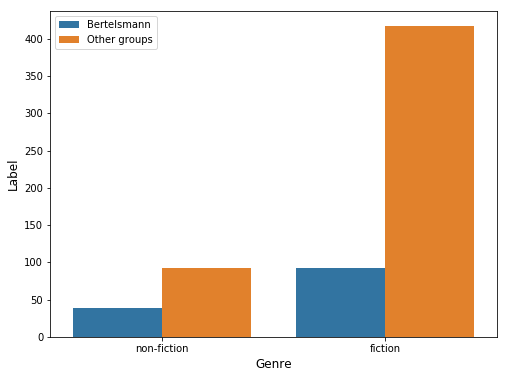

In [11]:
# generate count plot for different groups 
create_hist_to_compare_different_groups(comparsion_genres, df_new_grouped, column_club)

#### Conculsion 
* the percentage of non-fiction books for scholar is higher compared to non-scholars
* to confirm the above we will plot all the groups without spliting them into 2 groups 


In [13]:
df_ficition_notgrouped, df_ficition_notgrouped_percentage = generate_comparsion_dataframe(comparsion_genres, df[['club_name','genre','title']],'club_name')
df_ficition_grouped.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


count               percentage             
club_classified Bertelsmann Other groups Bertelsmann Other groups
genre                                                            
fiction                  92          417   70.769231    81.925344
non-fiction              38           92   29.230769    18.074656

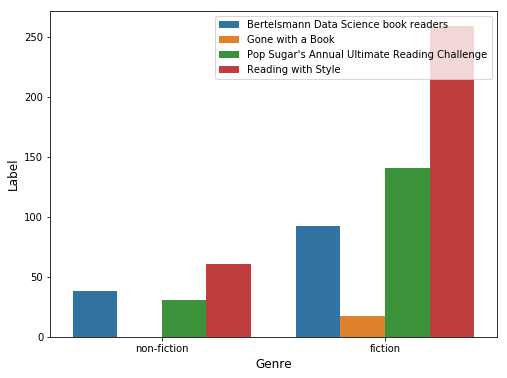

In [14]:
create_hist_to_compare_different_groups(comparsion_genres, df[['club_name','genre','title']], 'club_name')

###  2) distribution of different fiction books genres liked by users 
* compare the difference in interest when we split the groups in two by combining all the non-Bertelsmann into one group(other) and Bertelsmann group 
* generate a df summarizing the count and percent of each genre for each group
* generate percentage and count plot for the new group
* compare the groups individiulaly 

In [16]:
comparsion_genres = ['science-fiction','history','classics','fantasy','romance']
column_club = 'club_classified'
df_ficition_grouped, df_ficition_grouped_percentage = generate_comparsion_dataframe(comparsion_genres, df_new_grouped,'club_classified')
df_ficition_grouped.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


count               percentage             
club_classified Bertelsmann Other groups Bertelsmann Other groups
genre                                                            
classics                 54          158   29.347826    26.421405
fantasy                  46          122   25.000000    20.401338
history                  34          164   18.478261    27.424749
romance                  17           82    9.239130    13.712375
science-fiction          33           72   17.934783    12.040134

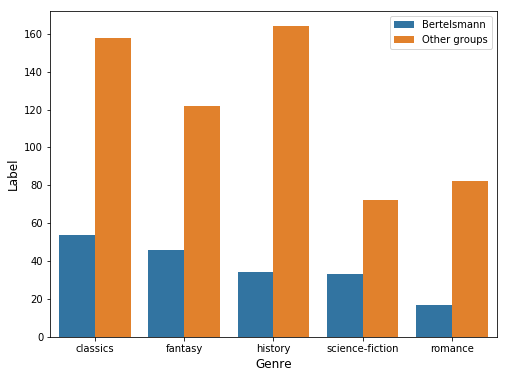

In [17]:
create_hist_to_compare_different_groups(comparsion_genres, df_new_grouped, column_club)

#### Conculsion 
* the percentage of science-fiction books for scholar is higher compared to non-scholars and a lower percentage of romance books
* to confirm the above we will plot all the groups without spliting them into 2 groups 


In [19]:
df_ficition_notgrouped, df_ficition_notgrouped_percentage = generate_comparsion_dataframe(comparsion_genres, df[['club_name','genre','title']],'club_name')
df_ficition_grouped.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


count               percentage             
club_classified Bertelsmann Other groups Bertelsmann Other groups
genre                                                            
classics                 54          158   29.347826    26.421405
fantasy                  46          122   25.000000    20.401338
history                  34          164   18.478261    27.424749
romance                  17           82    9.239130    13.712375
science-fiction          33           72   17.934783    12.040134

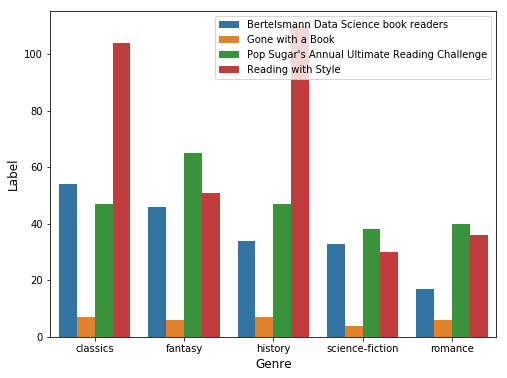

In [20]:
create_hist_to_compare_different_groups(comparsion_genres, df[['club_name','genre','title']], 'club_name')

###  3) Adult or young-adult in different groups 
* compare the difference in interest when we split the groups in two by combining all the non-Bertelsmann into one group(other) and Bertelsmann group 
* generate a df summarizing the count and percent of each genre for each group
* generate percentage and count plot for the new group
* compare the groups individiulaly 

In [21]:
comparsion_genres = ['adult','young-adult']
column_club = 'club_classified'
df_ficition_grouped, df_ficition_grouped_percentage = generate_comparsion_dataframe(comparsion_genres, df_new_grouped,'club_classified')
df_ficition_grouped.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


count               percentage             
club_classified Bertelsmann Other groups Bertelsmann Other groups
genre                                                            
adult                    29          159   54.716981    66.806723
young-adult              24           79   45.283019    33.193277

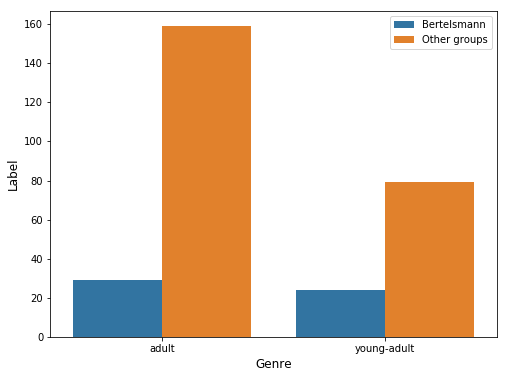

In [22]:
create_hist_to_compare_different_groups(comparsion_genres, df_new_grouped, column_club)

#### Conculsion 
* the percentage of young-adults books for scholar is higher compared to non-scholars 
* to confirm the above we will plot all the groups without spliting them into 2 groups 


In [23]:
df_ficition_notgrouped, df_ficition_notgrouped_percentage = generate_comparsion_dataframe(comparsion_genres, df[['club_name','genre','title']],'club_name')
df_ficition_grouped.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


count               percentage             
club_classified Bertelsmann Other groups Bertelsmann Other groups
genre                                                            
adult                    29          159   54.716981    66.806723
young-adult              24           79   45.283019    33.193277

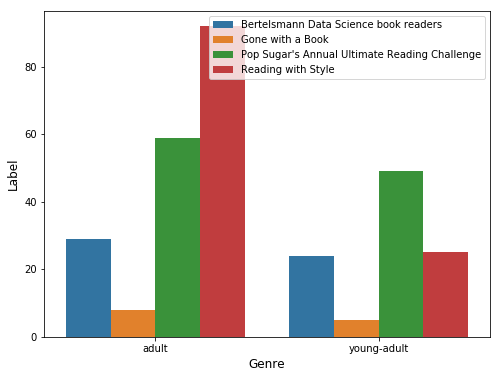

In [24]:
create_hist_to_compare_different_groups(comparsion_genres, df[['club_name','genre','title']], 'club_name')

### 4) how much we read more personal-development or philosphy in different groups 


In [26]:
comparsion_genres = ['personal-development','philosophy']
column_club = 'club_classified'
df_ficition_grouped, df_ficition_grouped_percentage = generate_comparsion_dataframe(comparsion_genres, df_new_grouped,'club_classified')
df_ficition_grouped.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


count               percentage             
club_classified      Bertelsmann Other groups Bertelsmann Other groups
genre                                                                 
personal-development        16.0          NaN   35.555556          NaN
philosophy                  29.0          1.0   64.444444        100.0

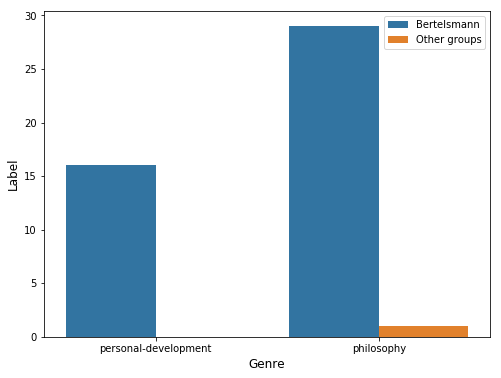

In [27]:
create_hist_to_compare_different_groups(comparsion_genres, df_new_grouped, column_club)

#### Conculsion 
* the percentage of personal-development books for scholar is higher compared to non-scholars 
* to confirm the above we will plot all the groups without spliting them into 2 groups 


###  4) rating distribution of books  
* compare the rating of books across groups 
* generate percentage and count plot for the new group
* we can notice for both groups the mean of rating is 4 and range is from 3 -4.6 

In [31]:
df_new_grouped_rating = pd.DataFrame.copy(df[['club_name','avg_rating','title']])
df_new_grouped_rating['club_classified'] = np.where(df_new_grouped_rating['club_name']=='Bertelsmann Data Science book readers', 'Bertelsmann', 'Other groups')
del df_new_grouped_rating['club_name']


In [32]:
df_new_grouped_rating[df_new_grouped_rating['club_classified'] == 'Bertelsmann']['avg_rating'].describe()


count    706.000000
mean       4.035297
std        0.327427
min        3.000000
25%        3.900000
50%        4.045000
75%        4.230000
max        4.620000
Name: avg_rating, dtype: float64

In [33]:
df_new_grouped_rating[df_new_grouped_rating['club_classified'] == 'Other groups']['avg_rating'].describe()


count    2471.000000
mean        3.920749
std         0.293943
min         2.940000
25%         3.800000
50%         3.960000
75%         4.080000
max         4.610000
Name: avg_rating, dtype: float64

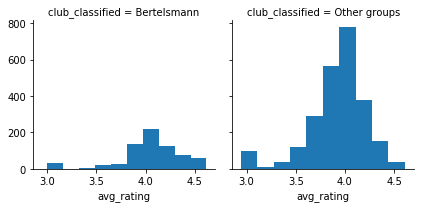

In [34]:
g=sns.FacetGrid(data=df_new_grouped_rating,col='club_classified')
g.map(plt.hist,'avg_rating')


###  5) popularity of books from the ratings count
* are Bertelsmann scholars interested in popular books more?
* compare the rating of books across groups 
* generate percentage plot for the Bertelsmann aganist all other groups 


In [35]:
df_new_grouped_cnt = pd.DataFrame.copy(df[['club_name','ratings_cnt','title']])
df_new_grouped_cnt['club_classified'] = np.where(df_new_grouped_cnt['club_name']=='Bertelsmann Data Science book readers', 'Bertelsmann', 'Other groups')
del df_new_grouped_cnt['club_name']


In [36]:
# divide the ratings count into 8 divisons to make it easier to compare 
segmented_count = df_new_grouped_cnt.groupby([pd.qcut(df_new_grouped_cnt['ratings_cnt'], q=8),'club_classified']).count()
segmented_count['title'].unstack()

club_classified,Bertelsmann,Other groups
ratings_cnt,,
"(14.999, 4041.0]",76,322
"(4041.0, 10664.0]",76,322
"(10664.0, 27715.0]",48,354
"(27715.0, 66520.0]",56,340
"(66520.0, 142123.0]",65,327
"(142123.0, 325000.0]",115,289
"(325000.0, 722243.0]",107,285
"(722243.0, 5357646.0]",163,232


In [42]:
segmented_count['title'].unstack(level=1)

club_classified,Bertelsmann,Other groups
ratings_cnt,,
"(14.999, 4041.0]",76,322
"(4041.0, 10664.0]",76,322
"(10664.0, 27715.0]",48,354
"(27715.0, 66520.0]",56,340
"(66520.0, 142123.0]",65,327
"(142123.0, 325000.0]",115,289
"(325000.0, 722243.0]",107,285
"(722243.0, 5357646.0]",163,232


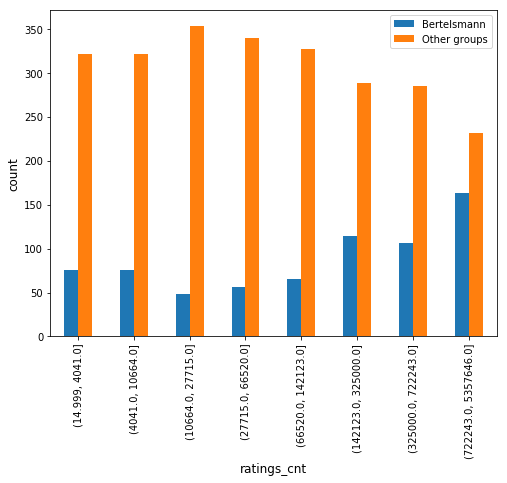

In [44]:
segmented_count['title'].unstack(level=1).plot(kind='bar', figsize = (8,6))
plt.legend(loc='best', fontsize = 10)
plt.xlabel('ratings_cnt', size = 12)
plt.ylabel('count', size = 12)
plt.tick_params(axis='both',which='both',labelsize=10)


In [37]:
# calculate the percentage of each ratings count divison for Bertelsmann and other groups

segement_cnt2 = df_new_grouped_cnt.groupby([pd.qcut(df_new_grouped_cnt['ratings_cnt'], q=10),'club_classified'])['title'].agg({'percentage':'count'})
segement_cnt2_percentage = segement_cnt2.groupby(level='club_classified').apply(lambda x: 100 * x / float(x.sum()))
segement_cnt2_percentage.unstack()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


percentage             
club_classified       Bertelsmann Other groups
ratings_cnt                                   
(14.999, 3228.0]         9.915014    10.117361
(3228.0, 7316.0]         6.515581    10.926750
(7316.0, 15321.0]        8.215297    10.602995
(15321.0, 34494.0]       6.373938    11.129098
(34494.0, 66520.0]       5.240793    11.371914
(66520.0, 121068.0]      5.240793    11.169567
(121068.0, 215497.0]    13.031161     9.186564
(215497.0, 455428.0]    13.031161     9.065156
(455428.0, 952885.0]    12.464589     9.793606
(952885.0, 5357646.0]   19.971671     6.636989

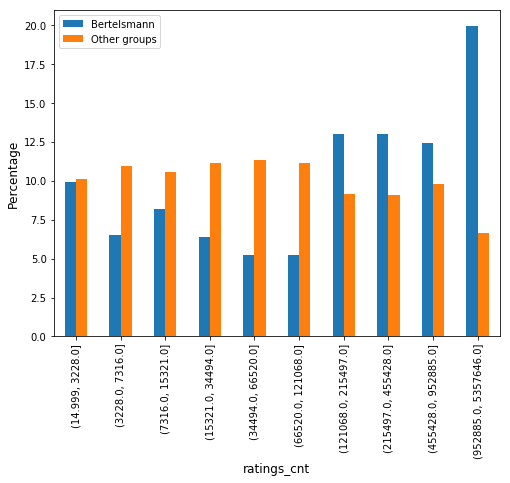

In [45]:
# plot the percentage of each 
segement_cnt2_percentage.unstack(level=1).plot(kind='bar',  y = 'percentage',figsize = (8,6))
plt.legend(loc='best', fontsize = 10)
plt.xlabel('ratings_cnt', size = 12)
plt.ylabel('Percentage', size = 12)
plt.tick_params(axis='both',which='both',labelsize=10)


##### conculsion
* we divided the ratings count into 8 divisons to make it easier to plot and group the rating count
* we can notice that for books with ratings of 121068 Bertelsmann scholars read more compare to the other groups


### 6) genres popular across the groups 
* what are the top 5 most common genres for each group 
* popular genres for Bertelsmann were: ficition, novel, classics, literature, fantasy while other groups had fiction, novel, history, adult, classics 

In [46]:

df_g_count = df_new_grouped.groupby(["club_classified","genre"])['title'].count()
g_percentage = df_g_count.groupby(level='club_classified').apply(lambda x: 100 * x / float(x.sum()))

g2 = g_percentage.groupby(level=0, group_keys=False)
g2.nlargest(5)

club_classified  genre     
Bertelsmann      fiction       13.031161
                 novel          9.631728
                 classics       7.648725
                 literature     7.082153
                 fantasy        6.515581
Other groups     fiction       16.875759
                 novel          7.001214
                 history        6.636989
                 adult          6.434642
                 classics       6.394172
Name: title, dtype: float64

In [47]:
df_g_count = df.groupby(["club_name","genre"])['title'].count()
g_percentage = df_g_count.groupby(level='club_name').apply(lambda x: 100 * x / float(x.sum()))

g2 = g_percentage.groupby(level=0, group_keys=False)
g2.nlargest(5)

club_name                                      genre      
Bertelsmann Data Science book readers          fiction        13.031161
                                               novel           9.631728
                                               classics        7.648725
                                               literature      7.082153
                                               fantasy         6.515581
Gone with a Book                               fiction        15.596330
                                               novel           9.174312
                                               adult           7.339450
                                               classics        6.422018
                                               history         6.422018
Pop Sugar's Annual Ultimate Reading Challenge  fiction        16.077537
                                               fantasy         7.411631
                                               adult           6.727480
     